<a href="https://colab.research.google.com/github/Hisernberg/linkdin-projects/blob/main/vision_transformer_using_pytorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as dataloder
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR


In [33]:
tranformation_operation = transforms.Compose([transforms.ToTensor()])

In [34]:
train_dataset = torchvision.datasets.MNIST(root='./data', train = True, download=True, transform= tranformation_operation)


In [35]:
val_dataset = torchvision.datasets.MNIST(root='./data', train = False, download=True, transform= tranformation_operation)

In [36]:
train_data = dataloder.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data =dataloder.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [52]:
batch_size = 64
number_classes = 10
image_size = 28
patch_size = 7
number_of_patches = (image_size // patch_size) **2
attention_head = 4
embedding_dim= 16
transformer_blocks=4
mlp_nodes = 64
number_channels =1
epoch = 5

In [38]:
#patch embedding
class patch_embedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(number_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)


    def forward(self,x):
       x=self.patch_embed(x)
       x=x.flatten(2)
       x=x.transpose(1,2)
       return x



In [39]:
#mlp head for classification
class MLP_Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embedding_dim)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, number_classes)
        )
    def forward(self, x):
      #x=x[:,0]
      x=self.layernorm1(x)
      x=self.mlp_head(x)
      return x

In [40]:
#transformer encoder class
#layer normalization
#mlp attention
#layer normalization
#residual
#mlp - activation function

class transformer_encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.multi_attention = nn.MultiheadAttention(embedding_dim, attention_head,batch_first = True)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, mlp_nodes),
            nn.GELU(),
            nn.Linear(mlp_nodes, embedding_dim),
            nn.GELU(),
            nn.Linear(embedding_dim, embedding_dim),
        )


    def forward(self,x):
       residual1 = x
       x = self.layer_norm1(x)
       x = self.multi_attention(x, x, x)[0]
       x = residual1 + x

       residual2 = x
       x = self.layer_norm2(x)
       x = self.mlp(x)
       x = residual2 + x
       return x

In [41]:
class vision_transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = patch_embedding()
        self.position_embedding = nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dim))
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.transformer_encoder = nn.Sequential(*[transformer_encoder() for _ in range(transformer_blocks)])
        self.mlp_head = MLP_Head()

    def forward(self,x):
        x = self.patch_embedding(x)
        b=x.shape[0]
        cls_token = self.class_token.expand(b, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.position_embedding
        x = self.transformer_encoder(x)
        x=x[:,0]
        x = self.mlp_head(x)
        return x

In [42]:
#optimizer
#cross entropy loss
# device for cuda


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vision_transformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()



In [59]:
for epoch in range(epoch):
    train_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Predictions
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()  # Step LR scheduler after each epoch

    epoch_loss = train_loss / len(train_data)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

In [60]:
print(f"\nTraining finished. Final Training Accuracy: {epoch_acc:.2f}%")

# Evaluation on validation set
model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_acc = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_acc:.2f}%")


Training finished. Final Training Accuracy: 93.40%
Validation Accuracy: 94.16%


## optimizing the model using hyper perameters

In [70]:
import torch.profiler

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/mnist_vit_train'),
    record_shapes=True,
    profile_memory=True,
    with_stack=True
) as prof:
    for epoch_i in range(epoch):
        train_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for images, labels in train_data:
            prof.step()
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        epoch_loss = train_loss / len(train_data)
        epoch_acc = 100 * correct / total

        print(f"Epoch [{epoch_i+1}/{epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

In [62]:
train_data = dataloder.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_data = dataloder.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Model optimization

Consider techniques like mixed precision training, gradient accumulation, or model pruning.


In [63]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

for epoch in range(epoch):
    train_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    epoch_loss = train_loss / len(train_data)
    epoch_acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/{epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

print(f"\nTraining finished. Final Training Accuracy: {epoch_acc:.2f}%")

model.eval()
val_correct = 0
val_total = 0
with torch.no_grad():
    for images, labels in val_data:
        images, labels = images.to(device), labels.to(device)
        with autocast():
            outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_acc = 100 * val_correct / val_total
print(f"Validation Accuracy: {val_acc:.2f}%")


Training finished. Final Training Accuracy: 93.40%


/tmp/ipython-input-63-3867750478.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-63-3867750478.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation Accuracy: 94.16%


## Hardware optimization
Ensure you are utilizing your hardware effectively, potentially by adjusting batch size or using multiple GPUs if available.


In [64]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

else:
    print("CUDA is not available. Using CPU.")

train_data = dataloder.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_data = dataloder.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

print(f"Using batch size: {batch_size}")


CUDA is available. Using GPU: Tesla T4
Using batch size: 64


In [68]:
import torch
import torch.nn as nn
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
import copy


hyperparameter_combinations = [
    {'lr': 0.001, 'optimizer': 'AdamW', 'step_size': 5, 'gamma': 0.5},
    {'lr': 0.01, 'optimizer': 'AdamW', 'step_size': 5, 'gamma': 0.5},
    {'lr': 0.001, 'optimizer': 'SGD', 'step_size': 5, 'gamma': 0.5},
    {'lr': 0.01, 'optimizer': 'SGD', 'step_size': 5, 'gamma': 0.5},
]

best_val_accuracy = 0.0
best_hyperparameters = None
results = []

experiment_epochs = 3

for i, combo in enumerate(hyperparameter_combinations):
    print(f"Experiment {i+1}/{len(hyperparameter_combinations)} with hyperparameters: {combo}")


    model = vision_transformer().to(device)

    if combo['optimizer'] == 'AdamW':
        optimizer = AdamW(model.parameters(), lr=combo['lr'])
    elif combo['optimizer'] == 'SGD':
        optimizer = SGD(model.parameters(), lr=combo['lr'])
    else:
        raise ValueError("Unsupported optimizer")

    scheduler = StepLR(optimizer, step_size=combo['step_size'], gamma=combo['gamma'])
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    for epoch_i in range(experiment_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_data:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        epoch_loss = train_loss / len(train_data)
        epoch_acc = 100 * correct / total
        print(f"  Epoch [{epoch_i+1}/{experiment_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        with autocast():
            for images, labels in val_data:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"  Validation Accuracy: {val_acc:.2f}%")

    results.append({'hyperparameters': combo, 'validation_accuracy': val_acc})

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_hyperparameters = combo

print("\n--- Experiment Summary ---")
for res in results:
    print(f"Hyperparameters: {res['hyperparameters']}, Validation Accuracy: {res['validation_accuracy']:.2f}%")

print(f"\nBest performing hyperparameters: {best_hyperparameters}")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

Experiment 1/4 with hyperparameters: {'lr': 0.001, 'optimizer': 'AdamW', 'step_size': 5, 'gamma': 0.5}


/tmp/ipython-input-68-680585500.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-68-680585500.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Epoch [1/3], Loss: 0.7484, Accuracy: 75.87%
  Epoch [2/3], Loss: 0.2205, Accuracy: 93.42%
  Epoch [3/3], Loss: 0.1653, Accuracy: 94.94%


/tmp/ipython-input-68-680585500.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  Validation Accuracy: 94.37%
Experiment 2/4 with hyperparameters: {'lr': 0.01, 'optimizer': 'AdamW', 'step_size': 5, 'gamma': 0.5}
  Epoch [1/3], Loss: 0.4157, Accuracy: 86.83%
  Epoch [2/3], Loss: 0.1914, Accuracy: 94.11%
  Epoch [3/3], Loss: 0.1604, Accuracy: 95.08%
  Validation Accuracy: 95.70%
Experiment 3/4 with hyperparameters: {'lr': 0.001, 'optimizer': 'SGD', 'step_size': 5, 'gamma': 0.5}
  Epoch [1/3], Loss: 2.3252, Accuracy: 11.15%
  Epoch [2/3], Loss: 2.2982, Accuracy: 11.24%
  Epoch [3/3], Loss: 2.2957, Accuracy: 11.24%
  Validation Accuracy: 11.35%
Experiment 4/4 with hyperparameters: {'lr': 0.01, 'optimizer': 'SGD', 'step_size': 5, 'gamma': 0.5}
  Epoch [1/3], Loss: 2.2928, Accuracy: 14.09%
  Epoch [2/3], Loss: 1.7678, Accuracy: 38.88%
  Epoch [3/3], Loss: 0.7103, Accuracy: 79.47%
  Validation Accuracy: 84.89%

--- Experiment Summary ---
Hyperparameters: {'lr': 0.001, 'optimizer': 'AdamW', 'step_size': 5, 'gamma': 0.5}, Validation Accuracy: 94.37%
Hyperparameters: {'lr':

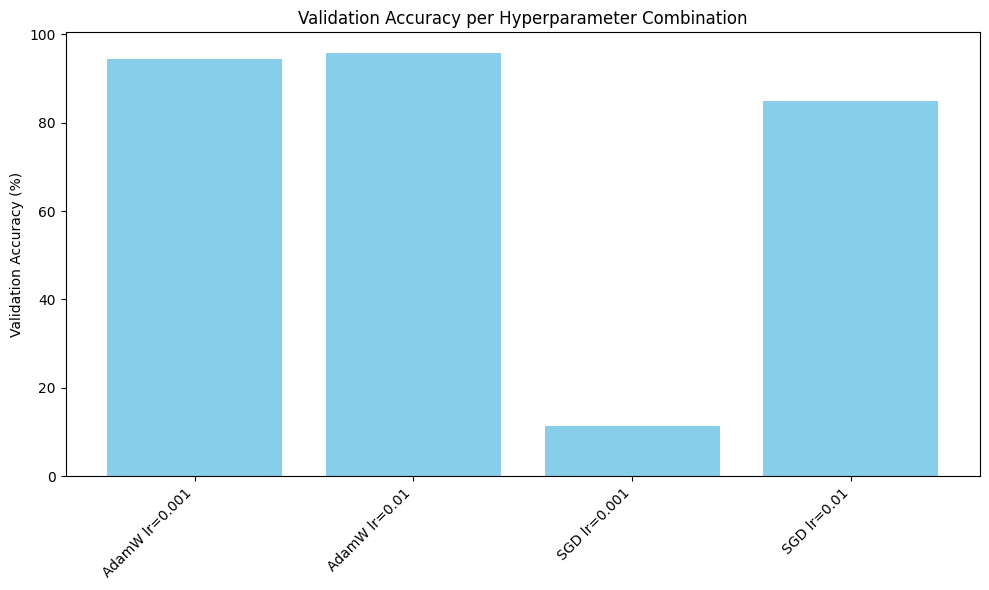

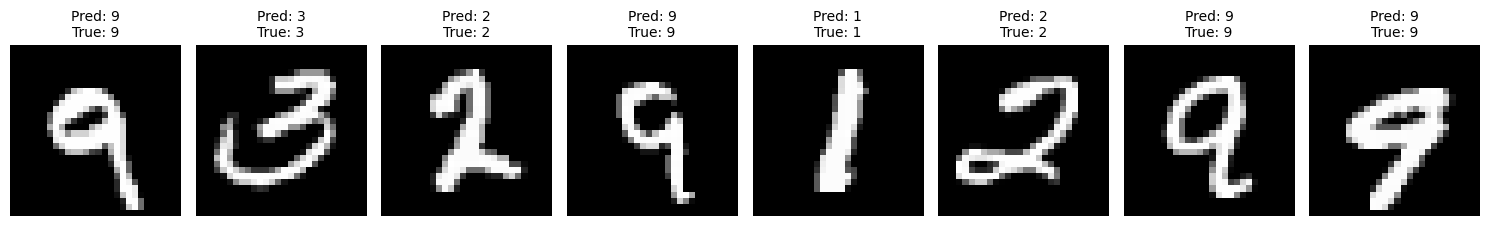

In [80]:
import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []

val_accuracies_from_experiments = [res['validation_accuracy'] for res in results]

plt.figure(figsize=(10, 6))
x_labels = [f"{res['hyperparameters']['optimizer']} lr={res['hyperparameters']['lr']}" for res in results]
plt.bar(x_labels, val_accuracies_from_experiments, color='skyblue')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy per Hyperparameter Combination')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



dataiter = iter(val_data)
images, labels = next(dataiter)


images = images.to(device)


model.eval()
with torch.no_grad():
    outputs = model(images)


_, predicted = torch.max(outputs.data, 1)


num_images_to_show = 8
fig = plt.figure(figsize=(15, 5))
for i in range(num_images_to_show):
    ax = fig.add_subplot(1, num_images_to_show, i+1)

    img = images[i].cpu().numpy().squeeze()
    plt.imshow(img, cmap='gray')
    ax.set_title(f'Pred: {predicted[i].item()}\nTrue: {labels[i].item()}', fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()